In [17]:
from tardis_pytorch.utils.load_data import load_mrc_file

image, px = load_mrc_file('../../../../../Downloads/ts11.mrc_26.80Apx.mrc')

In [2]:
from tardis_pytorch.dist_pytorch.utils.build_point_cloud import BuildPointCloud

post_processes = BuildPointCloud()
pc_hd, pc_ld = post_processes.build_point_cloud(
                image=image, EDT=True, down_sampling=5,
            )

In [3]:
from tardis_pytorch.utils.visualize_pc import VisualizePointCloud
VisualizePointCloud(pc_ld, False)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [4]:
from tardis_pytorch.dist_pytorch.datasets.patches import PatchDataSet
patch_pc = PatchDataSet(
                max_number_of_points=1000, graph=False
            )
coords_df, _, output_idx, _ = patch_pc.patched_dataset(
                    coord=pc_ld
                )

In [5]:
from tardis_pytorch.utils.predictor import Predictor

graphs = []
predict_dist = Predictor(
                network="dist",
                subtype="triang",
                model_type="microtubules",
                device='mps',
            )

for id_dist, coord in enumerate(coords_df):
    graph = predict_dist.predict(x=coord[None, :])
    graphs.append(graph)

Searching for weight file for dist_triang...


In [23]:
pc_ld = pc_ld * 26.8
pc_ld[:, 0] = pc_ld[:, 0]
pc_ld[:, 1] = pc_ld[:, 1]
pc_ld[:, 2] = pc_ld[:, 2]

In [26]:
from tardis_pytorch.dist_pytorch.utils.segment_point_cloud import PropGreedyGraphCut


GraphToSegment = PropGreedyGraphCut(
                    threshold=0.5, smooth=True
                )

segments = GraphToSegment.patch_to_segment(
                    graph=graphs, coord=pc_ld, idx=output_idx, prune=10
                )

In [24]:
from tardis_pytorch.utils.visualize_pc import VisualizeFilaments
import numpy as np
VisualizeFilaments(segments)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [27]:
from tardis_pytorch.utils.spline_metric import FilterSpatialGraph
filter_splines = FilterSpatialGraph(
                    connect_seg_if_closer_then=2500,
                    cylinder_radius=250,
                    filter_short_segments=500,
                )

segments_filter = filter_splines(segments=segments)

VisualizeFilaments(segments_filter)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [32]:
from tardis_pytorch.utils.load_data import ImportDataFromAmira

am = ImportDataFromAmira('../../../../../Downloads/ts11.mrc_26.80Apx_SpatialGraph.am')
coord = am.get_segmented_points()

am = ImportDataFromAmira('../../../../../Downloads/ts11.mrc_26.80Apx_SpatialGraph_filter.am')
coord_filter = am.get_segmented_points()

In [33]:
VisualizeFilaments(coord_filter)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [8]:
from tardis_pytorch.spindletorch.data_processing.draw_mask import draw_instances

c = coord_filter
c[:, 1:] = c[:, 1:] / 26.8
mask = draw_instances(mask_size=image.shape, coordinate=coord_filter, pixel_size=26.8, circle_size=250, label=True)

In [5]:
from tardis_pytorch.spindletorch.data_processing.draw_mask import draw_semantic_membrane
mask = draw_semantic_membrane(
                    mask_size=image.shape,
                    coordinate=coord_filter,
                    pixel_size=26.8,
                    spline_size=60,
                )

In [11]:
import tifffile.tifffile as tiff

tiff.imwrite('../../../../../Downloads/ts11.mrc_26.80Apx_SpatialGraph_filter.tif', mask)

In [9]:
import numpy as np
np.unique(mask)

array([0, 1], dtype=uint8)

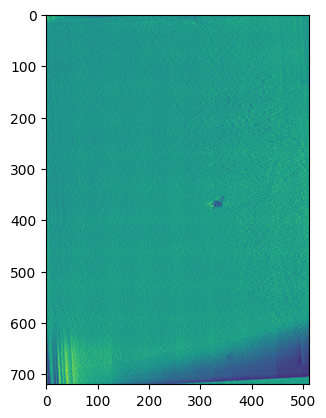

In [21]:
import matplotlib.pyplot as plt

plt.imshow(np.flip(image, 1)[200, :])